In [1]:
import pandas as pd
import numpy as np
from glob import glob 
import sys
sys.path += ["../src"]
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.decomposition import PCA


### Grid

In [2]:
def get_df_bins(df_, df_real, bin_size = 0.01):
    df = df_.copy()

    bins_x = np.arange(df_real["x"].min() - bin_size / 2, df_real["x"].max() + bin_size / 2, bin_size)
    bins_y = np.arange(df_real["y"].min() - bin_size / 2, df_real["y"].max() + bin_size / 2, bin_size)

    df["bin_x"] = pd.cut(df["x"], bins = bins_x, labels = np.arange(len(bins_x)-1))
    df["bin_y"] = pd.cut(df["y"], bins = bins_y, labels = np.arange(len(bins_y)-1))
    df.drop(columns = ["x", "y"], inplace = True)

    return df


In [ ]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    df_real = get_df_bins(data["df_real"].copy(), data["df_real"])
    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data[k], data["df_real"])
            dist = np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).sum(axis = 1).mean()
            all_geo_features[prov][k] = dist

            

In [78]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv", index_col = 0)
#df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


In [79]:
df_geo_features.T.mean().sort_values()

df_real                     0.000000
df_copula_nf                0.528000
df_nfvae                    0.604806
df_copula_ablation          0.607509
df_shuffle_cap_num          0.609606
df_shuffle_cap_bins         0.628722
df_shuffle_province_num     0.745881
df_shuffle_province_bins    0.779049
df_ablation                 0.782489
dtype: float64

<Axes: >

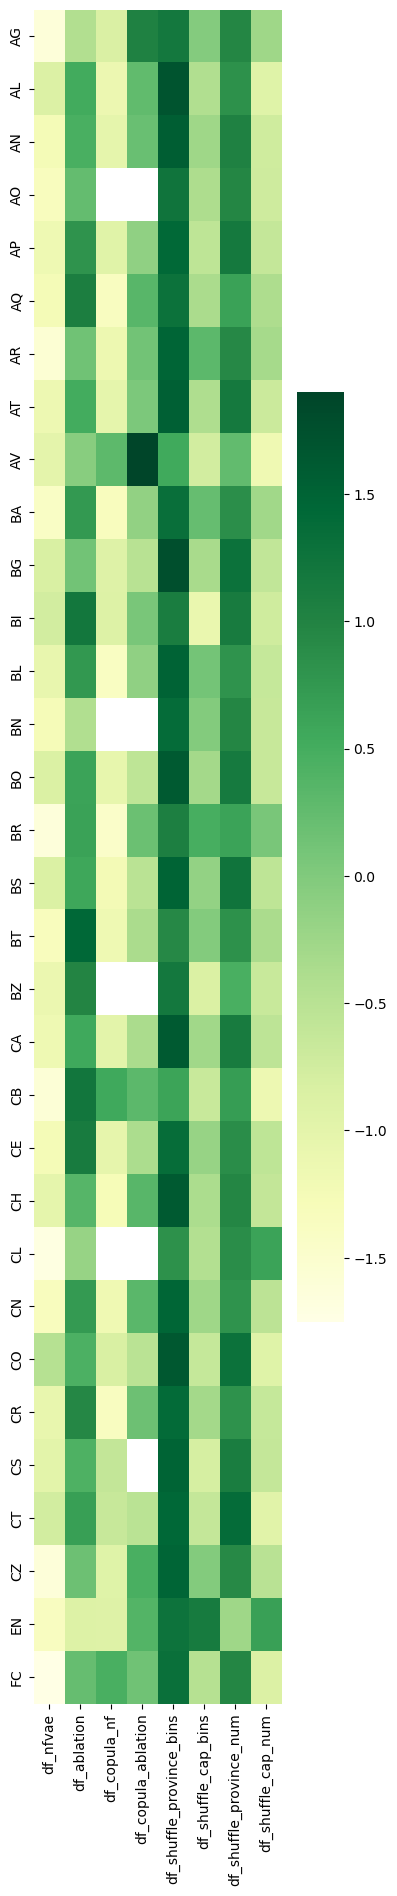

In [6]:
fig, axes = sbp(figsize = (4,22))

sns.heatmap(df_geo_features.T, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

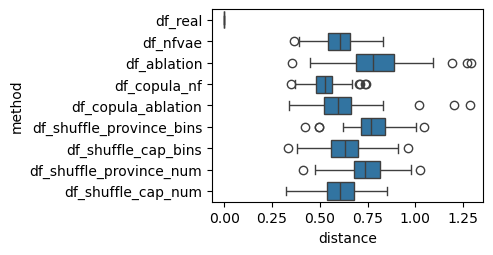

In [80]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), y = "method", x = "distance")

### Grid PCA

In [6]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    pca = PCA(n_components = 27)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    n_components95 = (pca.explained_variance_ratio_.cumsum() < .95).sum()


    data_pca = {k: pd.concat([data[k][["x", "y"]], pd.DataFrame(pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,:n_components95])], axis = 1) for k in data if "95" not in k}
    df_real = get_df_bins(data_pca["df_real"].copy(), data_pca["df_real"])

    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data_pca[k], data_pca["df_real"])
            dist = (np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).mean() * pca.explained_variance_ratio_[:n_components95]).sum()
            all_geo_features[prov][k] = dist

            

In [11]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_isp.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_isp.csv", index_col = 0)
#df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


In [12]:
df_geo_features.T.mean().sort_values()

df_real                     0.000000
df_copula_nf                0.378339
df_nfvae                    0.386305
df_shuffle_cap_num          0.405373
df_shuffle_cap_bins         0.422601
df_copula_ablation          0.438929
df_ablation                 0.490228
df_shuffle_province_num     0.501716
df_shuffle_province_bins    0.523230
dtype: float64

<Axes: xlabel='distance', ylabel='method'>

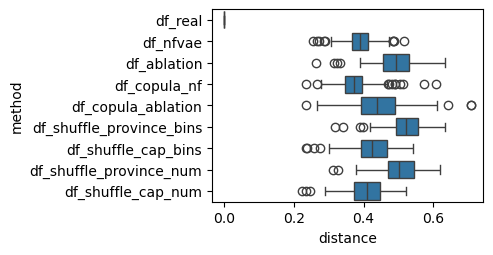

In [13]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), y = "method", x = "distance")

### Spatial autocorrelation

In [3]:
from spatial_autocorrelation import get_moransI, get_localMoransI
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import geopandas as gpd
from jl_synthetic_ipf_all_provinces import get_area_from_xy

In [4]:
import jl_vae
geo_dict = jl_vae.load_geo_data()    

In [ ]:
# compute Morans index
# W is the distance weight, can be modified 
def compute_spatial_autocorrelation(df, var, D = None, k = 20, local_moran = False, weighting = "within_CAP"):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326")
#    gdf = gdf.to_crs(epsg=3857)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326")

    if weighting == "within_CAP":
        cap = get_area_from_xy(df, geo_dict["cap"]).fillna(0)
        W = (np.array(cap.astype(int))[:,None] - np.array(cap.astype(int))[None,:] == 0) + 0.
    
    if weighting == "nearest_k":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])

        n = coords.shape[0]

        nn = NearestNeighbors(n_neighbors = k + 1, metric = "euclidean").fit(coords)
        dists, inds = nn.kneighbors(coords)         
        dists, inds = dists[:,1:], inds[:,1:] # remove self
            
        weights = np.exp(-dists / np.median(dists))
        
        row_idx = np.repeat(np.arange(n), k)
        col_idx = inds.ravel()
        w_ij = weights.ravel()

        W = csr_matrix((w_ij, (row_idx, col_idx)), shape=(n, n))

        # make symmetric by averaging (optional but common)
        W = 0.5 * (W + W.T)
        W = W.todense()

    if weighting == "dist_threshold":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        threshold = np.percentile(dists, 1)
        W = (dists < threshold) + 0.
    
    if weighting == "exp":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        
        W = np.exp(-dists / np.percentile(dists,1))
        W = W * (dists < np.percentile(dists,10))

    if local_moran:
        return get_localMoransI(W,np.array(df[var]), list(df.index))
    else:
        return get_moransI(W,np.array(df[var]))
    

In [ ]:
moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat", 
                                                 local_moran = False) for k in data_pca}

In [9]:
all_geo_features = {}
for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    pca = PCA(n_components = 27)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    n_components95 = (pca.explained_variance_ratio_.cumsum() < .95).sum()


    data_pca = {k: pd.concat([data[k][["x", "y"]], pd.DataFrame(pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,:n_components95])], axis = 1) for k in data if "95" not in k}
    break


In [ ]:
# within_CAP 4.1 s 0.08
# nearest_k 4.2 s 0.31
# dist_threshold 4.7 s 0.08
# exp 6.2 s 0.07


moran_pca = {k:{comp: compute_spatial_autocorrelation(data_pca[k],  comp, k = 20,
                                local_moran = False, weighting = "nearest_k") for comp in range(n_components95)}
                                for k in data_pca}

{k:pd.Series(moran_pca[k]) @ pca.explained_variance_ratio_[:n_components95] for k in moran_pca}

In [23]:
pd.Series(moran_pca["df_ablation"]) @  pca.explained_variance_ratio_[:n_components95]

0.2273919168874715

{'df_real': 0.13493821183756347,
 'df_nfvae': 0.19391835501380267,
 'df_ablation': 0.2273919168874715,
 'df_copula_nf': 0.016378031107733785,
 'df_copula_ablation': 0.017416656262535832,
 'df_shuffle_province_bins': 0.07603066317619894,
 'df_shuffle_cap_bins': 0.061238313283268314,
 'df_shuffle_province_num': 0.07173805624182482,
 'df_shuffle_cap_num': 0.049390480156500494}

In [252]:
moran_prov = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
        
    with open(file, 'rb') as f:
        data = pickle.load(f)
    print(prov)
    print(len(data["df_real"]))

    pca = PCA(n_components = 1)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    #print(pca.explained_variance_)
    data_pca = {k: data[k][["x", "y"]].assign(feat = pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,0]) for k in data if "95" not in k}

    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat", 
                                                 local_moran = False) for k in data_pca}
    
    moran_prov[prov] = moran_pca




AG
1181
AL
3542
AN
4252
AO
1455
AP
2633
AQ
1332
AR
4158
AT
1614
AV
1635
BA
17753
BG
13287
BI
1019
BL
1464
BN
1004
BO
13583
BR
3525
BS
10444
BT
4790
BZ
1588
CA
6370
CB
1127
CE
5258
CH
2858
CL
673
CN
3338
CO
7926
CR
2694
CS
2170
CT
3444
CZ
1386
EN
535
FC
3354
FE
2493
FG
4665
FI
18012
FM
1007
FR
1312
GE
13272
GO
1184
GR
2280
IM
2493
IS
245
KR
397
LC
4645
LE
6294
LI
2739
LO
2160
LT
3918
LU
3248
MB
11465
MC
2275
ME
2971
MI
52052
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jlenti/miniconda3/envs/synpop/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1559795/4281954060.py", line 16, in <module>
    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat",
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1559795/4281954060.py", line 16, in <dictcomp>
    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat",
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1559795/1542215252.py", line 53, in compute_spatial_autocorrelation
    return get_moransI(W,np.array(df[var]))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jlenti/miniconda3/envs/synpop/lib/python3.11/site-packages/spatial_autocorrelation/moransI.py", line None, in get_moransI
KeyboardInterrupt

During handling of the

In [5]:
with open(f"/data/housing/data/intermediate/jl_pop_synth/spatial_autocorrelation/spatial_autocorrelation/moran_exp_AG_pca.pkl", "rb") as f:
                    moran = pickle.load(f)

In [6]:
moran

{'AG': {'df_real': 0.08399540151840777,
  'df_nfvae': 0.14247332456945372,
  'df_ablation': 0.13387459920062683,
  'df_copula_nf': 0.01195115254375989,
  'df_copula_ablation': 0.0068235934605011955,
  'df_shuffle_province_bins': 0.03386926066074696,
  'df_shuffle_cap_bins': 0.03642843366773913,
  'df_shuffle_province_num': 0.03128053043086388,
  'df_shuffle_cap_num': 0.028116941341469814}}

In [18]:
dict_moran = {}
weighting = "dist_threshold"
#weighting = "within_CAP"
#weighting = "nearest_k"
#weighting = "exp"

for file in sorted(glob(f"/data/housing/data/intermediate/jl_pop_synth/spatial_autocorrelation/spatial_autocorrelation/moran_{weighting}_*_pca.pkl")):
    prov = file.split(".")[-2].split("_")[-2]
    if len(prov) == 2:
        with open(file, "rb") as f:
            moran = pickle.load(f)
        
        dict_moran[prov] = moran[prov]
df_moran = pd.DataFrame(dict_moran)

In [ ]:
#df_moran.T.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_moran_{weighting}_isp.csv")

<Axes: xlabel="moran's I", ylabel='method'>

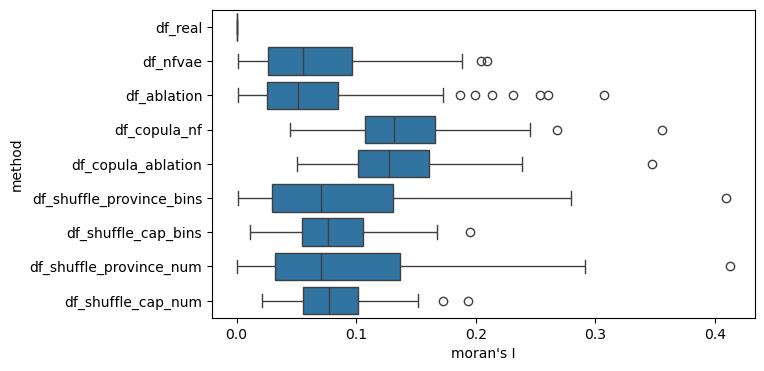

In [14]:
fig, axes = sbp(figsize = (7,4))

sns.boxplot(data = pd.DataFrame(df_moran).fillna(0).apply(lambda x: np.abs(x- x["df_real"])).stack().reset_index().rename(columns = {"level_0": "method", "level_1": "feature",0: "moran's I"}),
#sns.boxplot(data = pd.DataFrame(df_moran).fillna(0).stack().reset_index().rename(columns = {"level_0": "method", "level_1": "feature",0: "moran's I"}),
              x = "moran's I", y = "method")



In [22]:
1

1

In [75]:
pd.DataFrame((df_moran > 0.1) + 0.).T.corr()#apply(lambda x: (x - x.loc["df_real"])**2).mean(axis = 1)

,df_real,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_bins,df_shuffle_cap_bins,df_shuffle_province_num,df_shuffle_cap_num
df_real,1.000000,0.334876,0.645497,NaN,NaN,0.161349,0.316933,0.215754,0.398996
df_nfvae,0.334876,1.000000,0.355335,NaN,NaN,0.202572,0.151204,0.240791,0.240791
df_ablation,0.645497,0.355335,1.000000,NaN,NaN,0.175412,0.218218,0.320508,0.228934
df_copula_nf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
df_copula_ablation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
df_shuffle_province_bins,0.161349,0.202572,0.175412,NaN,NaN,1.000000,-0.143542,0.815202,-0.180710
df_shuffle_cap_bins,0.316933,0.151204,0.218218,NaN,NaN,-0.143542,1.000000,-0.134885,0.794325
df_shuffle_province_num,0.215754,0.240791,0.320508,NaN,NaN,0.815202,-0.134885,1.000000,-0.169811
df_shuffle_cap_num,0.398996,0.240791,0.228934,NaN,NaN,-0.180710,0.794325,-0.169811,1.000000


In [49]:
df = data["df_real"].copy()
coords = np.asarray(df)
k = 10
if True:
    n = coords.shape[0]

    nn = NearestNeighbors(n_neighbors = k + 1, metric = "euclidean").fit(coords)
    dists, inds = nn.kneighbors(coords)         
    dists, inds = dists[:,1:], inds[:,1:] # remove self
        
    weights = np.exp(-dists / np.median(dists))
    
    row_idx = np.repeat(np.arange(n), k)
    col_idx = inds.ravel()
    w_ij = weights.ravel()

    W = csr_matrix((w_ij, (row_idx, col_idx)), shape=(n, n))

    # make symmetric by averaging (optional but common)
    W = 0.5 * (W + W.T)


In [34]:
df_ = data["df_real"]
D = pairwise_distances(np.array(df_[["x", "y"]]))

In [16]:
W = np.exp(-D)

In [41]:
k = 10
coords = np.asarray(data["df_real"][["x", "y"]])
n = coords.shape[0]

nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(coords)
dists, inds = nn.kneighbors(coords)           # includes self at [:,0]
dists, inds = dists[:,1:], inds[:,1:] 

In [43]:
dists.shape

(13583, 10)

In [12]:
compute_spatial_autocorrelation(df_, "log_price")

0.99729852

In [21]:
import sklearn
print(sklearn.__version__)

1.2.2


In [12]:
def morans_I_sparse(W, y):
    """
    Moran's I using sparse weight matrix W (csr_matrix).
    y is a 1D numpy array.
    """
    n = len(y)
    y = y.astype(float)
    y_mean = y.mean()
    y_diff = y - y_mean

    # denominator
    denom = np.sum(y_diff ** 2)

    # numerator (efficient sparse multiplication)
    num = y_diff @ (W @ y_diff)

    # normalization factor
    W_sum = W.sum()

    I = (n / W_sum) * (num / denom)
    return I


In [14]:
for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_BO.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
        
    with open(file, 'rb') as f:
        data = pickle.load(f)
    break


In [4]:
import geopandas as gpd

In [16]:
weighting = "dist_threshold"
df = data["df_real"]
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326")
#    gdf = gdf.to_crs(epsg=3857)
if True:
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326")

    if weighting == "within_CAP":
        cap = get_area_from_xy(df, geo_dict["cap"]).fillna(0)
        W = (np.array(cap.astype(int))[:,None] - np.array(cap.astype(int))[None,:] == 0) + 0.
    
    if weighting == "nearest_k":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])

        n = coords.shape[0]

        nn = NearestNeighbors(n_neighbors = k + 1, metric = "euclidean").fit(coords)
        dists, inds = nn.kneighbors(coords)         
        dists, inds = dists[:,1:], inds[:,1:] # remove self
            
        weights = np.exp(-dists / np.median(dists))
        
        row_idx = np.repeat(np.arange(n), k)
        col_idx = inds.ravel()
        w_ij = weights.ravel()

        W = csr_matrix((w_ij, (row_idx, col_idx)), shape=(n, n))

        # make symmetric by averaging (optional but common)
        W = 0.5 * (W + W.T)
        W = W.todense()

    if weighting == "dist_threshold":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        threshold = np.percentile(dists, 1)
        W = (dists < threshold) + 0.
    
    if weighting == "exp":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        
        W = np.exp(-dists / np.percentile(dists,1))
        W = W * (dists < np.percentile(dists,10))


In [ ]:

    if local_moran:
        return get_localMoransI(W,np.array(df[var]), list(df.index))
    else:
        return get_moransI(W,np.array(df[var]))
    

In [9]:
var = "log_price"

In [17]:
get_moransI(W,np.array(df[var]))

0.16383777

In [18]:
morans_I_sparse(csr_matrix(W), np.array(df[var]))

0.16383776687945914